## Aim
* Given a stereo output directory, evaluate how the completeness and accuracy of products for Colorado Conifers
* We aim to use consistent framework to evaluate the outputs from different stereo correlators
* Our end goal for the project is to ensure that the quality of GPU stereo correlator outputs is as good as their CPU counterparts

### Some potential metrics we are going to compute

* Disparity Completeness --> Done
* Vertical elevation residual from LiDAR, with respect to slope --> maybe in future, landcover classes --> Done
* time taken to complete the processing with difference correlation strategies --> Done
* CPU/GPU/memory load distribution --> todo
* Consistent parameters for all the implementations for a particular algorithm kernel combination output for best accuracy
* DEM stereo parameters used to be written in a dataframe which is easily digestible (maybe submit to ASP plot once complete?)


#### Disparity completeness
* Read the filtered disparity map, compute the valid pixels from the good-pixel map?

In [5]:
%cd /panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd/WV01WV01_20190930_102001008BD60800_1020010088168700/cpu

/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd/WV01WV01_20190930_102001008BD60800_1020010088168700/cpu


In [6]:
ls

asp_block/  asp_sgm/  opencv_block/  opencv_sgbm/


In [52]:
import os,glob
import shapely
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box
import requests
from scipy import stats
import rasterio
import rioxarray 
from pyproj import CRS
import geopandas as gpd
import numpy as np
import contextily

import pystac_client
import odc.stac

In [8]:
def calc_valdispperc(dem_dir):
    '''
    Given an output DEM directory, locate filtered disparity file (-F.tif) and rectified left image file (-L.tif) 
    to calculate aggregate percent valid disparity
    '''
    print(f'............. Working on {dem_dir} .............')
    print(f'Reading in filtered disparity map')
    # read in filtered disparity points F.tif (outliers have been removed)
    filtered_disp_fn = glob.glob(os.path.join(dem_dir, '*-F.tif'))[0]
    filtered_disparity = rioxarray.open_rasterio(filtered_disp_fn,masked=True).isel(band=0)
    valid_non_zero_disparity = np.count_nonzero(filtered_disparity)
    
    print(f'Reading in rectified left input image')    
    # read in original input points L.tif
    left_img_fn = glob.glob(os.path.join(dem_dir, '*-L.tif'))[0]
    l_img = rioxarray.open_rasterio(left_img_fn,masked=True).isel(band=0)
    left_img_count = l_img.count()
    print(f'Calculating percent valid disparity')        
    # calculate valid disparity
    val_disp_perc = (valid_non_zero_disparity/left_img_count)*100
    print(f'{val_disp_perc:0.2f}')
    return val_disp_perc

In [9]:
stereo_results = sorted(glob.glob('*/'))


In [6]:
stereo_results

['asp_block/', 'asp_sgm/', 'opencv_block/', 'opencv_sgbm/']

In [7]:
%%time
valid_disp_perc_list = [calc_valdispperc(results) for results in stereo_results]

............. Working on asp_block/ .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
50.89
............. Working on asp_sgm/ .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
66.16
............. Working on opencv_block/ .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
14.26
............. Working on opencv_sgbm/ .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
54.39
CPU times: user 32.3 s, sys: 8.7 s, total: 41 s
Wall time: 41.8 s


In [8]:
for idx,valid_disp_percentage in enumerate(valid_disp_perc_list):
    print(f"Percentage of valid pixels using {stereo_results[idx].split('/')[0]} is {valid_disp_percentage:.2f}")

Percentage of valid pixels using asp_block is 50.89
Percentage of valid pixels using asp_sgm is 66.16
Percentage of valid pixels using opencv_block is 14.26
Percentage of valid pixels using opencv_sgbm is 54.39


## Vertical elevation difference from LiDAR

In [10]:
stereo_results 

['asp_block/', 'asp_sgm/', 'opencv_block/', 'opencv_sgbm/']

In [16]:
cpu_dsm_fn

['asp_block/asp_block_processing-DEM.tif',
 'asp_sgm/asp_sgm_processing-DEM.tif',
 'opencv_block/opencv_block_processing-DEM.tif',
 'opencv_sgbm/opencv_sgbm_processing-DEM.tif']

In [17]:
#%%time
reference_lidar_fn = '../lidar_reference/DSM_98_percentile_CO_WestCentral_2019-DSM_mos_nuth_x-0.03_y-0.19_z-0.40_align_align_asp_stack.tif'
cpu_dsm_fn = [glob.glob(os.path.join(result,'*DEM.tif'))[0] for result in stereo_results]
opencv_bm_dsm = rioxarray.open_rasterio(cpu_dsm_fn[2],masked=True).isel(band=0)
opencv_sgm_dsm = rioxarray.open_rasterio(cpu_dsm_fn[3],masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)
asp_sgm_dsm = rioxarray.open_rasterio(cpu_dsm_fn[1],masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)
asp_bm_dsm = rioxarray.open_rasterio(cpu_dsm_fn[0],masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)

lidar_reference = rioxarray.open_rasterio(reference_lidar_fn,masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)

In [18]:
%%time

cpu_dsm_list = [asp_bm_dsm,asp_sgm_dsm,opencv_bm_dsm,opencv_sgm_dsm]
residual_list = [cpu_dsm - lidar_reference for cpu_dsm in cpu_dsm_list]

CPU times: user 80.9 ms, sys: 954 μs, total: 81.8 ms
Wall time: 80.2 ms


In [19]:
len(cpu_dsm_list)

4

In [20]:
##this is from coincident, maybe just run this notebook using the coincident environment?
from typing import Any
from osgeo import gdal, gdal_array
def gdaldem(
    da: xr.DataArray, subcommand: str = "hillshade", **kwargs: Any
) -> xr.DataArray:
    """
    Use GDAL python bindings to perform gdaldem operations

    Parameters
    ----------
    da: xarray.DataArray
        Dataarray containing elevation values
    subcommand: str
        'hillshade' (default), 'aspect', 'slope'
    kwargs: dict
        https://gdal.org/en/stable/api/python/utilities.html#osgeo.gdal.DEMProcessingOptions

    Returns
    -------
    da: xarray.DataArray
        XArray dataset with result of running GDAL algorithm
    """
    # Ensure we're working with a 2D Array
    elevation = da.squeeze()
    src = gdal_array.OpenArray(elevation.to_numpy())
    geotransform = da.rio.transform().to_gdal()
    src.SetGeoTransform(geotransform)

    ds_gdal = gdal.DEMProcessing("", src, subcommand, format="MEM", **kwargs)
    numpy_result = ds_gdal.ReadAsArray()

    if subcommand != "hillshade":
        numpy_result[numpy_result == -9999] = np.nan

    del ds_gdal

    return elevation.copy(data=numpy_result)

CPU times: user 3.79 s, sys: 159 ms, total: 3.95 s
Wall time: 3.97 s


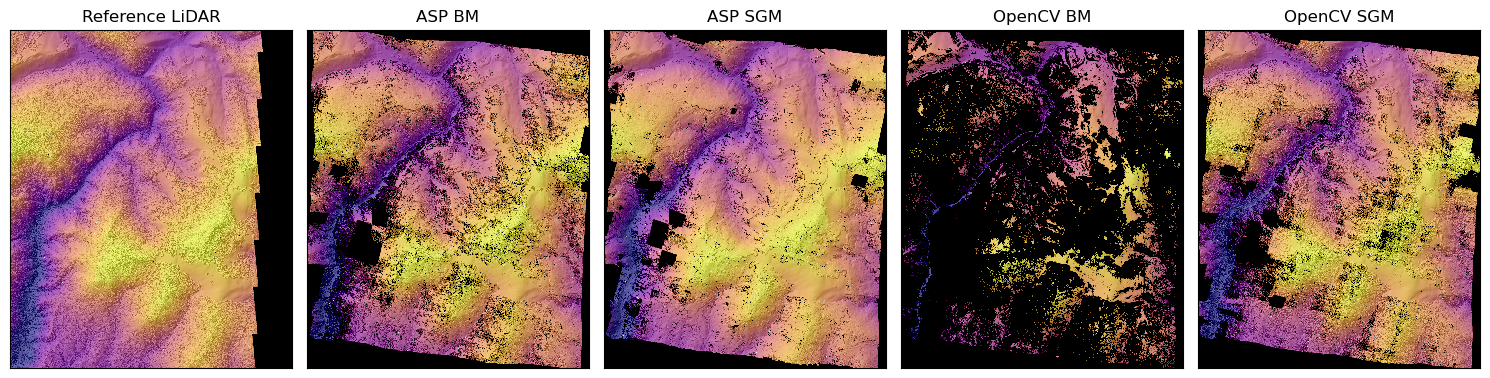

In [50]:
%%time
title_list = ['Reference LiDAR',  'ASP BM', 'ASP SGM','OpenCV BM', 'OpenCV SGM']
#title_list = ['Reference LiDAR',  'ASP SGM','OpenCV BM', 'OpenCV SGM']
cmin = np.nanpercentile(lidar_reference.to_numpy(),2)
cmax = np.nanpercentile(lidar_reference.to_numpy(),98)
alpha = 0.6
f,ax = plt.subplots(1,5,figsize=(15,4),sharex=True,sharey=True)
#f,ax = plt.subplots(1,4,figsize=(15,4),sharex=True,sharey=True)
for idx,axa in enumerate(ax.ravel()):
    if idx==0:
        hillshade = gdaldem(lidar_reference)
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        lidar_reference.plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    else:
        hillshade = gdaldem(cpu_dsm_list[idx-1])
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        cpu_dsm_list[idx-1].plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    axa.set_title(title_list[idx])
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('gray')

plt.tight_layout()

In [48]:
%matplotlib inline

In [47]:

slope_forest_xlim = (np.float64(349634.085106383), np.float64(351160.89361702127))
slope_forest_ylim = (np.float64(4293947.985815602), np.float64(4295262.737588652))
non_forest_slope_xlim = (np.float64(350260.32925909164), np.float64(351401.8261656859))
non_forest_slope_ylim = (np.float64(4293424.837332126), np.float64(4293916.628489512))


### Some Zoom-ins

CPU times: user 4.33 s, sys: 297 ms, total: 4.63 s
Wall time: 4.66 s


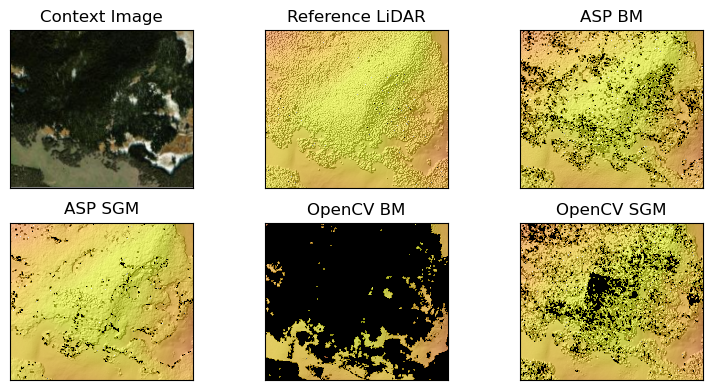

In [60]:
%%time
title_list = ['Context Image','Reference LiDAR','ASP BM', 'ASP SGM', 'OpenCV BM', 'OpenCV SGM' ]
cmin = np.nanpercentile(lidar_reference.to_numpy(),2)
cmax = np.nanpercentile(lidar_reference.to_numpy(),98)
alpha = 0.6
f,ax = plt.subplots(2,3,figsize=(8,4),sharex=True,sharey=True)
for idx,axa in enumerate(ax.ravel()):
    if idx == 0:
        lidar_reference.plot(ax=axa,alpha=0,add_colorbar=False)
        contextily.add_basemap(ax=axa,source=contextily.providers.Esri.WorldImagery,attribution=False,crs=lidar_reference.rio.crs)
    elif idx==1:
        hillshade = gdaldem(lidar_reference)
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        lidar_reference.plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    else:
        hillshade = gdaldem(cpu_dsm_list[idx-2])
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        cpu_dsm_list[idx-2].plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    axa.set_title(title_list[idx])
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('gray')
    axa.set_xlim(slope_forest_xlim)
    axa.set_ylim(slope_forest_ylim)
plt.tight_layout()

CPU times: user 4.32 s, sys: 275 ms, total: 4.59 s
Wall time: 4.61 s


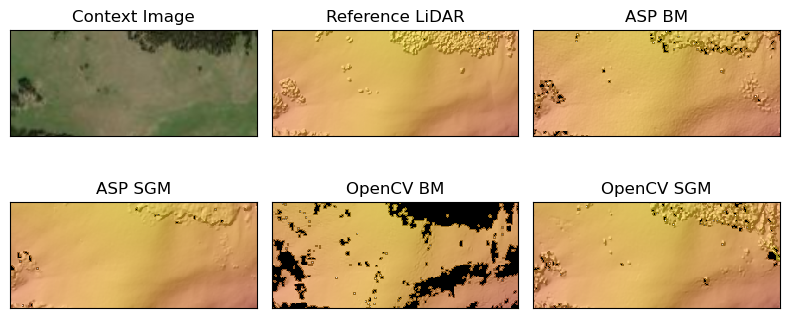

In [61]:
%%time
title_list = ['Context Image','Reference LiDAR','ASP BM', 'ASP SGM', 'OpenCV BM', 'OpenCV SGM' ]
cmin = np.nanpercentile(lidar_reference.to_numpy(),2)
cmax = np.nanpercentile(lidar_reference.to_numpy(),98)
alpha = 0.6
f,ax = plt.subplots(2,3,figsize=(8,4),sharex=True,sharey=True)
for idx,axa in enumerate(ax.ravel()):
    if idx == 0:
        lidar_reference.plot(ax=axa,alpha=0,add_colorbar=False)
        contextily.add_basemap(ax=axa,source=contextily.providers.Esri.WorldImagery,attribution=False,crs=lidar_reference.rio.crs)
    elif idx==1:
        hillshade = gdaldem(lidar_reference)
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        lidar_reference.plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    else:
        hillshade = gdaldem(cpu_dsm_list[idx-2])
        hillshade.plot(ax=axa,cmap='gray',add_colorbar=False)
        cpu_dsm_list[idx-2].plot(ax=axa,cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False,alpha=alpha)
    axa.set_title(title_list[idx])
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('gray')
    axa.set_xlim(non_forest_slope_xlim)
    axa.set_ylim(non_forest_slope_ylim)
plt.tight_layout()

In [22]:
def compute_med_nmad(da):
    med = da.median().values
    da_ar = da.to_numpy()
    da_non_nan = da_ar[~np.isnan(da_ar)]
    nmad = 1.4826*stats.median_abs_deviation(da_non_nan)
    return med,nmad

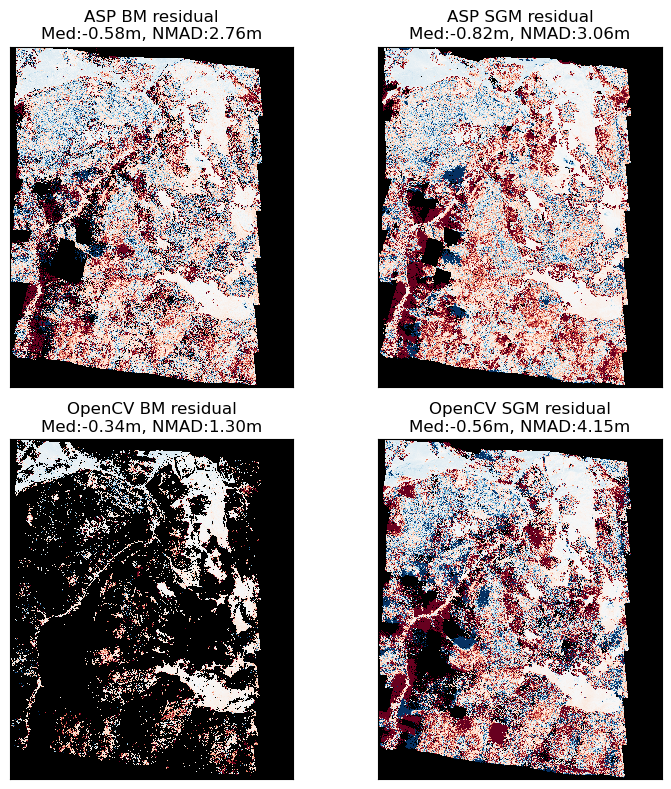

In [24]:
%%time
diff_clim = (-10,10)
f,ax = plt.subplots(2,2,figsize=(8,8))
title_base_list = ['ASP BM residual','ASP SGM residual','OpenCV BM residual','OpenCV SGM residual' ]
for idx,axa in enumerate(ax.ravel()):
    med,nmad = compute_med_nmad(residual_list[idx])
    title = title_base_list[idx]+f'\nMed:{med:.2f}m, NMAD:{nmad:.2f}m' 
    residual_list[idx].plot(ax=axa,cmap='RdBu',vmin=diff_clim[0],vmax=diff_clim[1],add_colorbar=False)
    axa.set_title(title)
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('k')
plt.tight_layout()

CPU times: user 265 ms, sys: 13.9 ms, total: 279 ms
Wall time: 280 ms


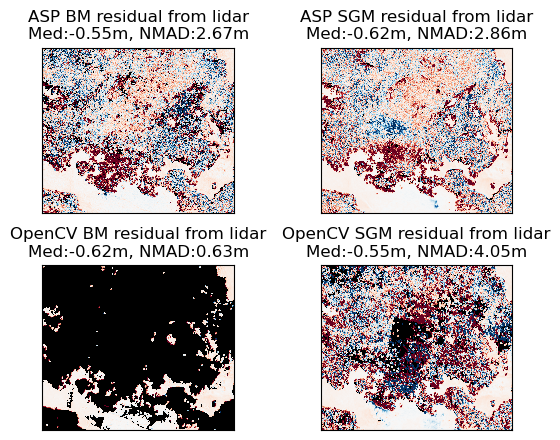

In [67]:

%%time
diff_clim = (-10,10)
f,ax = plt.subplots(2,2,figsize=(6,4.5))
title_base_list = ['ASP BM residual','ASP SGM residual','OpenCV BM residual','OpenCV SGM residual' ]
clip_xlim = slope_forest_xlim
clip_ylim = slope_forest_ylim
for idx,axa in enumerate(ax.ravel()):
    clipped_da = residual_list[idx].rio.clip_box(minx=clip_xlim[0], miny=clip_ylim[0], maxx=clip_ylim[0], maxy=clip_ylim[1])
    med,nmad = compute_med_nmad(clipped_da)
    title = title_base_list[idx]+f' from lidar\nMed:{med:.2f}m, NMAD:{nmad:.2f}m' 
    clipped_da.plot(ax=axa,cmap='RdBu',vmin=diff_clim[0],vmax=diff_clim[1],add_colorbar=False)
    axa.set_title(title)
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('k')
    axa.set_xlim(clip_xlim)
    axa.set_ylim(clip_ylim)
plt.tight_layout()

CPU times: user 188 ms, sys: 13.9 ms, total: 202 ms
Wall time: 202 ms


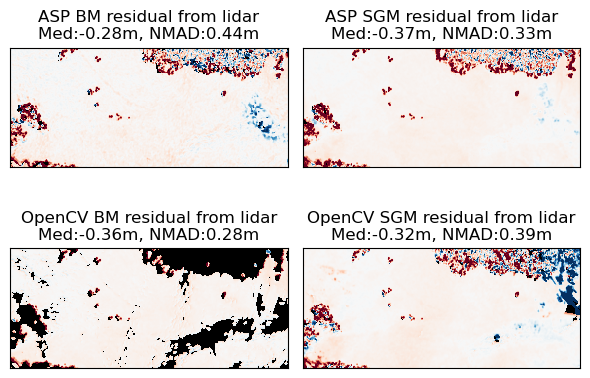

In [66]:

%%time
diff_clim = (-10,10)
f,ax = plt.subplots(2,2,figsize=(6,4.5),sharex=True,sharey=True)
title_base_list = ['ASP BM residual','ASP SGM residual','OpenCV BM residual','OpenCV SGM residual' ]
clip_xlim = non_forest_slope_xlim
clip_ylim = non_forest_slope_ylim
for idx,axa in enumerate(ax.ravel()):
    clipped_da = residual_list[idx].rio.clip_box(minx=clip_xlim[0], miny=clip_ylim[0], maxx=clip_ylim[0], maxy=clip_ylim[1])
    med,nmad = compute_med_nmad(clipped_da)
    title = title_base_list[idx]+f' from lidar\nMed:{med:.2f}m, NMAD:{nmad:.2f}m' 
    clipped_da.plot(ax=axa,cmap='RdBu',vmin=diff_clim[0],vmax=diff_clim[1],add_colorbar=False)
    axa.set_title(title)
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
    axa.set_facecolor('k')
    axa.set_xlim(clip_xlim)
    axa.set_ylim(clip_ylim)
plt.tight_layout()

### Add Worldcover based statistics

In [25]:
def get_esa_worldcover(
    bbox_input: gpd.GeoDataFrame
    | tuple
    | shapely.geometry.base.BaseGeometry
    | None = None,
    version: str = "v200",
    mask_nodata: bool = False,
) -> xr.DataArray:
    """
    Adapted from easysnowdata.remote_sensing.get_esa_worldcover (MIT license)
    Author: Eric Gagliano https://github.com/egagli/easysnowdata/blob/main/easysnowdata/remote_sensing.py
    Fetches 10m ESA WorldCover global land cover data (2020 v100 or 2021 v200) for a given bounding box.

    Description:
    The discrete classification maps provide 11 classes defined using the Land Cover Classification System (LCCS)
    developed by the United Nations (UN) Food and Agriculture Organization (FAO).

    Parameters
    ----------
    bbox_input
        GeoDataFrame containing the bounding box, or a tuple of (xmin, ymin, xmax, ymax), or a Shapely geometry.
    version
        Version of the WorldCover data. The two versions are v100 (2020) and v200 (2021). Default is 'v200'.
    mask_nodata
        Whether to mask no data values. Default is False.
        If False: (dtype=uint8, rio.nodata=0, rio.encoded_nodata=None)
        If True: (dtype=float32, rio.nodata=nan, rio.encoded_nodata=0)

    Returns
    -------
    worldcover_da
        WorldCover DataArray with class information in attributes.

    Examples
    --------
    >>> import geopandas as gpd
    >>> import easysnowdata
    >>>
    >>> # Define a bounding box for Mount Rainier
    >>> bbox = (-121.94, 46.72, -121.54, 46.99)
    >>>
    >>> # Fetch WorldCover data for the area
    >>> worldcover_da = easysnowdata.remote_sensing.get_esa_worldcover(bbox)
    >>>
    >>> # Plot the data using the example plot function
    >>> f, ax = worldcover_da.attrs['example_plot'](worldcover_da)

    Notes
    -----
    Data citation:
    Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A.,
    Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, Linlin,
    Tsendbazar, N.E., Ramoino, F., Arino, O. (2021). ESA WorldCover 10 m 2020 v100. doi:10.5281/zenodo.5571936.
    """

    def get_class_info():
        classes = {
            10: {"name": "Tree cover", "color": "#006400"},
            20: {"name": "Shrubland", "color": "#FFBB22"},
            30: {"name": "Grassland", "color": "#FFFF4C"},
            40: {"name": "Cropland", "color": "#F096FF"},
            50: {"name": "Built-up", "color": "#FA0000"},
            60: {"name": "Bare / sparse vegetation", "color": "#B4B4B4"},
            70: {"name": "Snow and ice", "color": "#F0F0F0"},
            80: {"name": "Permanent water bodies", "color": "#0064C8"},
            90: {"name": "Herbaceous wetland", "color": "#0096A0"},
            95: {"name": "Mangroves", "color": "#00CF75"},
            100: {"name": "Moss and lichen", "color": "#FAE6A0"},
        }
        return classes

    # Convert the input to a GeoDataFrame if it's not already one
    bbox_gdf = convert_bbox_to_geodataframe(bbox_input)

    if version == "v100":
        version_year = "2020"
    elif version == "v200":
        version_year = "2021"
    else:
        raise ValueError("Incorrect version number. Please provide 'v100' or 'v200'.")
    import planetary_computer

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    search = catalog.search(collections=["esa-worldcover"], bbox=bbox_gdf.total_bounds)
    worldcover_da = (
        odc.stac.load(
            search.items(), bbox=bbox_gdf.total_bounds, bands="map", chunks={}
        )["map"]
        .sel(time=version_year)
        .squeeze()
    )

    if mask_nodata:
        worldcover_da = worldcover_da.where(worldcover_da > 0)
        worldcover_da.rio.write_nodata(0, encoded=True, inplace=True)

    worldcover_da.attrs["class_info"] = get_class_info()
    # worldcover_da.attrs["cmap"] = get_class_cmap(worldcover_da.attrs["class_info"])
    worldcover_da.attrs["data_citation"] = (
        "Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A., Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, Linlin, Tsendbazar, N.E., Ramoino, F., Arino, O. (2021). ESA WorldCover 10 m 2020 v100. doi:10.5281/zenodo.5571936."
    )

    # worldcover_da.attrs['example_plot'] = plot_classes

    return worldcover_da


def fetch_worldcover(
    raster_fn: str, match_grid_da: xr.DataArray = None
) -> xr.DataArray:
    """
    Fetches ESA WorldCover data for a given raster file extent.
    This function retrieves the ESA WorldCover data for the area defined by the raster file's extent.

    Parameters
    ----------
    raster_fn
        Path to the raster file
    match_grid_da
        Match the grid of the output data array to this data array. Default is None.

    Returns
    -------
    da_wc
        A DataArray containing the ESA WorldCover data for the specified area.
    """

    with rasterio.open(raster_fn) as dataset:
        bounds = dataset.bounds
        bounds = rasterio.warp.transform_bounds(dataset.crs, "EPSG:4326", *bounds)
        bbox_gdf = gpd.GeoDataFrame(
            geometry=[shapely.box(*bounds)], crs="EPSG:4326", index=[0]
        )

    da_wc = get_esa_worldcover(bbox_gdf, mask_nodata=True)
    if match_grid_da is not None:
        da_wc = da_wc.rio.reproject_match(
            match_grid_da, resampling=rasterio.enums.Resampling.nearest
        )
    return da_wc

def convert_bbox_to_geodataframe(
    bbox_input: gpd.GeoDataFrame | tuple | shapely.geometry.base.BaseGeometry,
) -> gpd.GeoDataFrame:
    """
    Adapted from easysnowdata.remote_sensing.get_esa_worldcover (MIT license)
    Author: Eric Gagliano https://github.com/egagli/easysnowdata/blob/main/easysnowdata/utils.py
    Converts the input to a GeoDataFrame.

    This function takes various input formats representing a bounding box and converts them
    to a standardized GeoDataFrame format.

    Parameters
    ----------
    bbox_input : GeoDataFrame or tuple or Shapely geometry or None
        The input bounding box in various formats.

    Returns
    -------
    GeoDataFrame
        The converted bounding box as a GeoDataFrame.

    Notes
    -----
    If no bounding box is provided (None), it returns a GeoDataFrame representing the entire world.
    """
    if bbox_input is None:
        # If no bounding box is provided, use the entire world
        print("No spatial subsetting because bbox_input was not provided.")
        bbox_input = gpd.GeoDataFrame(
            geometry=[shapely.geometry.box(-180, -90, 180, 90)], crs="EPSG:4326"
        )
    if isinstance(bbox_input, gpd.GeoDataFrame):
        # If it's already a GeoDataFrame, return it
        return bbox_input
    if isinstance(bbox_input, tuple) and len(bbox_input) == 4:
        # If it's a tuple of four elements, treat it as (xmin, ymin, xmax, ymax)
        bbox_input = gpd.GeoDataFrame(
            geometry=[shapely.geometry.box(*bbox_input)], crs="EPSG:4326"
        )
    elif isinstance(bbox_input, shapely.geometry.base.BaseGeometry):
        # If it's a Shapely geometry, convert it to a GeoDataFrame
        bbox_input = gpd.GeoDataFrame(geometry=[bbox_input], crs="EPSG:4326")

    return bbox_input

In [26]:
da_wc = fetch_worldcover(cpu_dsm_fn[0],match_grid_da=residual_list[0])

In [29]:
def isolate_values_by_class(value_da,classification_da,classification_number):
    mask = classification_da == classification_number
    value = value_da.where(mask,np.nan).to_numpy()
    return value[~np.isnan(value)]

In [34]:
classified_tree_vals = isolate_values_by_class(opencv_bm_residual,da_wc,10)

In [30]:
def classified_stats(value_da,classification_da):
    classification_values = np.unique(classification_da.to_numpy())
    isolated_values = []
    for classification_value in classification_values:
        isolated_val = isolate_values_by_class(value_da,classification_da,classification_value)
        isolated_values.append(isolated_val)
    return classification_values,isolated_values

In [21]:
%%time
classification_values,isolated_values = classified_stats(opencv_bm_residual,da_wc)

CPU times: user 726 ms, sys: 4.7 ms, total: 731 ms
Wall time: 732 ms


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


CPU times: user 18.4 s, sys: 328 ms, total: 18.7 s
Wall time: 18.9 s


Text(0, 0.5, 'Num pixels')

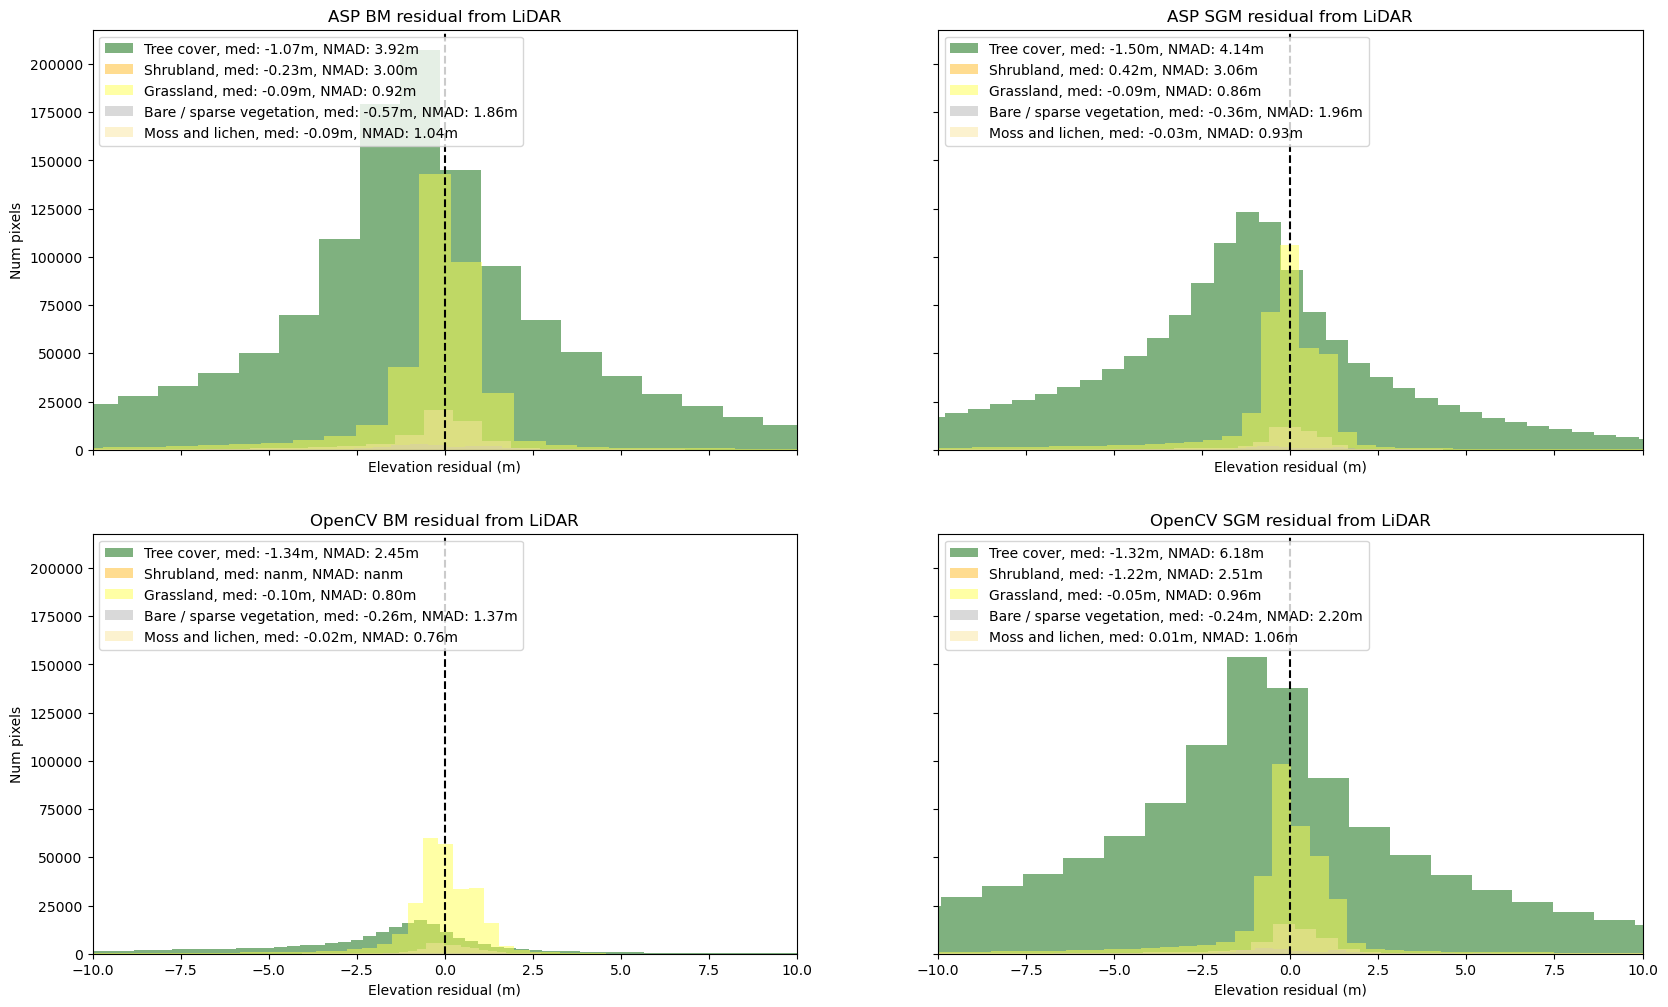

In [31]:
%%time
f,ax = plt.subplots(2,2,figsize=(20,12),sharey=True,sharex=True)
alpha = 0.5
bins = 1000

for b_idx,axa in enumerate(ax.ravel()):
    classification_values,isolated_values = classified_stats(residual_list[b_idx],da_wc)
    for idx,values in enumerate(isolated_values):
        color = da_wc.attrs['class_info'][classification_values[idx]]['color']
        class_name = da_wc.attrs['class_info'][classification_values[idx]]['name']
        med = np.median(values)
        nmad = stats.median_abs_deviation(values)*1.4826
        label = f'{class_name}, med: {med:.2f}m, NMAD: {nmad:.2f}m'
        axa.hist(values,alpha=alpha,bins=bins,color=color,label=label)
    axa.set_title(title_base_list[b_idx]+' from LiDAR')
    axa.set_xlim(-10,10)
    axa.axvline(x=0,c='k',linestyle='--')
    axa.legend(loc='upper left')
    axa.set_xlabel('Elevation residual (m)')

ax[0,0].set_ylabel('Num pixels')
ax[1,0].set_ylabel('Num pixels')


## Time taken by each process

In [37]:
opencv_bm_log_fn = '../../slurm-39196732.out'
opencv_sgm_log_fn = '../../slurm-39196733.out'
asp_sgm_log_fn = '../../slurm-39196731.out'
asp_block_log_fn = '../../slurm-39196728.out'

In [38]:
def find_time_taken_from_log(log_fn):
    substring = 'real'
    with open(log_fn, 'r') as file:
        line_number = 0
        for line in file:
            line_number += 1
            if substring in line:
               # print(f"Line {line_number}: {line.strip()}")
                time_taken = line.strip().split('\t')[1]
                break
        return time_taken

In [39]:
opencv_bm_real_time = find_time_taken_from_log(opencv_bm_log_fn)
opencv_sgm_real_time = find_time_taken_from_log(opencv_sgm_log_fn)
asp_block_real_time = find_time_taken_from_log(asp_block_log_fn)
asp_sgm_real_time = find_time_taken_from_log(asp_sgm_log_fn)

In [40]:
print(f"time take by ASP BM parallel_stereo in CPU mode: {asp_block_real_time}")
print(f"time take by ASP SGM parallel_stereo in CPU mode: {asp_sgm_real_time}")
print(f"time take by OpenCV BM parallel_stereo in CPU mode: {opencv_bm_real_time}")
print(f"time take by OpenCV SGM parallel_stereo in CPU mode: {opencv_sgm_real_time}")



time take by ASP BM parallel_stereo in CPU mode: 305m9.095s
time take by ASP SGM parallel_stereo in CPU mode: 62m14.239s
time take by OpenCV BM parallel_stereo in CPU mode: 31m16.551s
time take by OpenCV SGM parallel_stereo in CPU mode: 32m19.348s


## Takeaways

* OpenCV correlator produce results with more data gaps than ASP correlators
* The data gaps are highest over steep surfaces and vegetated surfaces, and ASP SGM produces more complete and less erroneous values over these surfaces
* The vertical accuracy for OpenCV correlator products are worse over vegetated surfaces, where an ASP-like implementation for the GPU-counterpart will be needed.
* Both OpenCV correlators take less time than their ASP counterparts, the OpenCV BM is slightly faster than OpenCV SGM